In [2]:
cd /home/nfcontrol/temp/rtcwleegfmri/RTCWLEEGFMRI/


/home/nfcontrol/temp/rtcwleegfmri/RTCWLEEGFMRI


In [3]:
ls

container_old.py  container.py~  core.py     __init__.py  __pycache__/
container.py      container.pyc  helpers.py  overview.py  ReceiveData.py


In [11]:
"""
Simple Python RDA client for the RDA tcpip interface of the BrainVision Recorder
It reads all the information from the recorded EEG,
prints EEG and marker information to the console and calculates and
prints the average power every second


Brain Products GmbH
Gilching/Freiburg, Germany
www.brainproducts.com

"""

# add path + get stuff from my container class -- usually this is the (longer) way
# of importing stuff from other directories... i.e. a genpath.
import sys
import os
sys.path.append(os.path.abspath("/media/data/Dropbox/Prog/python/Projects/rtcwleegfmri/RTCWLEEGFMRI/"))

# the glue that holds this pipeline together:
import container

# from IPython.core.debugger import Tracer
# this is to insert breakpoints/keyboards into this code.
from IPython.core import debugger
debug = debugger.Pdb().set_trace



# for my conventient plotting:
from matplotlib import pyplot as plt




# start the vacuuming:
import numpy as np


# needs socket and struct library
from socket import * # poor style, this.
from struct import *


import multiprocessing




#    from multiprocessing import Process
#    
#    class P(Process):
#        def __init__(self):
#            super(P, self).__init__()
#        def run(self):
#            print('hello')
#    
#    p = P()
#    p.start()
#    p.join()


# Marker class for storing marker information
class Marker(object):
    def __init__(self):
        self.position = 0
        self.points = 0
        self.channel = -1
        self.type = ""
        self.description = ""


class Receiver(multiprocessing.Process):
    
    def __init__(self,queue,ip_address,port,**kwargs):
        
        super(Receiver, self).__init__()

        # play around with **kwargs
        # one of them should probably be a socket.
        for key, value in kwargs.items():
            print("{0} = {1}".format(key, value))

        self.queue=queue
        self.ip_address=ip_address
        self.port=port
        self.exit = multiprocessing.Event()
        #debug()


    
    
    
    # Helper function for receiving whole message
    def RecvData(self,socket, requestedSize):
        returnStream = b''
        while len(returnStream) < requestedSize:
            databytes = socket.recv(requestedSize - len(returnStream))
            if databytes == '':
                raise(RuntimeError, "connection broken")
            returnStream += databytes
     
        return returnStream   
    
        
    # Helper function for splitting a raw array of
    # zero terminated strings (C) into an array of python strings
    # couldn't this be sped up with bisection search algorithm??
    # Helper function for splitting a raw array of
    # zero terminated strings (C) into an array of python strings
    # couldn't this be sped up with bisection search algorithm??
    def SplitString(self,raw_in_bytes_representation):
        # NEW! figured out the decoding convention new to python 3
        raw=raw_in_bytes_representation.decode('utf-8','backslashreplace')
        stringlist = []
        s = ""
        for i in range(len(raw)):
            if raw[i] != '\x00':
                s = s + raw[i]
            else:
                stringlist.append(s)
                s = ""
    
        return stringlist
    
    # Helper function for extracting eeg properties from a raw data array
    # read from tcpip socket
    #@profile
    def GetProperties(self,rawdata):
    
        # print rawdata
        # Extract numerical data
        (channelCount, samplingInterval) = unpack('<Ld', rawdata[:12])
    
        # Extract resolutions
        resolutions = []
        for c in range(channelCount):
            index = 12 + c * 8
            restuple = unpack('<d', rawdata[index:index+8])
            resolutions.append(restuple[0])
    
        # Extract channel names
        channelNames = self.SplitString(rawdata[12 + 8 * channelCount:])
        
    
        return (channelCount, samplingInterval, resolutions, channelNames)
    
    # Helper function for extracting eeg and marker data from a raw data array
    # read from tcpip socket   
    #@profile    
    def GetData(self,rawdata, channelCount):
    
        # Extract numerical data
        (block, points, markerCount) = unpack('<LLL', rawdata[:12])
    
        # Extract eeg data as array of floats
        data = []
        for i in range(points * channelCount):
            index = 12 + 4 * i
            value = unpack('<f', rawdata[index:index+4])
            data.append(value[0])
    
        # Extract markers
        markers = []
        index = 12 + 4 * points * channelCount
        for m in range(markerCount):
            markersize = unpack('<L', rawdata[index:index+4])
    
            ma = Marker()
            (ma.position, ma.points, ma.channel) = unpack('<LLl', rawdata[index+4:index+16])
            typedesc = self.SplitString(rawdata[index+16:index+markersize[0]])
            ma.type = typedesc[0]
            ma.description = typedesc[1]
    
            markers.append(ma)
            index = index + markersize[0]
    
        return (block, points, markerCount, data, markers)


##############################################################################################
#
# Main RDA routine
#
##############################################################################################
    
    #@profile
    def run(self):
    
            
        # Create a tcpip socket
        con = socket(AF_INET, SOCK_STREAM)
        # Connect to recorder host via 32Bit RDA-port
        # adapt to your host, if recorder is not running on local machine
        # change port to 51234 to connect to 16Bit RDA-port
        #con.connect(("10.42.0.195", 51244))
        # con.connect(("10.17.0.119", 51244))
        con.connect((self.ip_address, self.port))
        
        #con.connect(("10.42.0.195", 51244))
        
        
        # Flag for main loop
        finish = False
        
        # data buffer for calculation, empty in beginning
        data1s = []
        
        # block counter to check overflows of tcpip buffer
        lastBlock = -1
        
        #
        #from pycallgraph import PyCallGraph
        #from pycallgraph.output import GraphvizOutput
        #
        #with PyCallGraph(output=GraphvizOutput()):
        #    #code_to_profile()
            
        #### Main Loop ####
        # finish is used for a msg from Recorder; exit_is_set() is used
        # to exit from a signal from this computer.
        while not self.exit.is_set() and not finish:
        
            # Get message header as raw array of chars
            rawhdr = self.RecvData(con, 24)
        
            # Split array into usefull information id1 to id4 are constants
            (id1, id2, id3, id4, msgsize, msgtype) = unpack('<llllLL', rawhdr)
        
            # Get data part of message, which is of variable size
            rawdata = self.RecvData(con, msgsize - 24)
        
            # Perform action dependend on the message type
            if msgtype == 1:
                # Start message, extract eeg properties and display them
                (channelCount, samplingInterval, resolutions, channelNames) = self.GetProperties(rawdata)
                # reset block counter
                lastBlock = -1
        
                print("Start")
                print("Number of channels: " + str(channelCount))
                print("Sampling interval: " + str(samplingInterval))
                print("Resolutions: " + str(resolutions))
                print("Channel Names: " + str(channelNames))
        
        
                hdr={'channelCount':channelCount,'samplingInterval':samplingInterval,'resolutions':resolutions,'channelNames':channelNames}
                
                # define our nice little resulutions matrix, now, too.
                # firstdatareceived = False, because we just got the header!
                self.firstdatareceived=False
                
                
                # it works...
                # c.pass_hdr(hdr)
                self.queue.put({'hdr':hdr})
        
        
        
            elif msgtype == 4:
                # Data message, extract data and markers
                (block, points, markerCount, data, markers) = self.GetData(rawdata, channelCount)
        
                # for me, some diagnostical message!
                # print "Received block " + str(block) + " with " + str(points) + "Datapoints!"
        
                # so this will jam if you don't ac	quire some data for a while...
                # it's to get the resulutions_matrix, which is needed to convert the data somehow.
                if self.firstdatareceived is False:
                    # this operation/assignment only needs to be peformed once.
                    resolutions_matrix = np.matrix(np.ones(points)).transpose() * np.matrix(resolutions)
                    self.starting_block=block
                    self.firstdatareceived = True
                
                
                # convert data here to numpy arr.
                d = np.asarray(np.multiply(np.array(data).reshape(points,channelCount),resolutions_matrix))
                
                # so .. pass a NUMPY Array matrix, as well as the markers.
                
                self.queue.put({'d':d,'markers':markers,'block':block})
                #c.pass_data(d,markers,block)
        
        
                # print c.get_lastblock()
        
                #print block
                #print points
        
                # Check for overflow
                if lastBlock != -1 and block > lastBlock + 1:
                    print("*** Overflow with " + str(block - lastBlock) + " datablocks ***")
                lastBlock = block
        
                # Print markers, if there are some in actual block
                if markerCount > 0:
                    for m in range(markerCount):
                        print("Marker " + markers[m].description + " of type " + markers[m].type)
        
                # Put data at the end of actual buffer
                data1s.extend(data)
        
                # If more than 1s of data is collected, calculate average power, print it and reset data buffer
                if len(data1s) > channelCount * 1000000 / samplingInterval:
                    index = int(len(data1s) - channelCount * 1000000 / samplingInterval)
                    data1s = data1s[index:]
        
                    avg = 0
                    # Do not forget to respect the resolution !!!
                    for i in range(len(data1s)):
                        avg = avg + data1s[i]*data1s[i]*resolutions[i % channelCount]*resolutions[i % channelCount]
        
                    avg = avg / len(data1s)
                    print("Average power: " + str(avg))
        
                    data1s = []
        
        
        
                    
        
            elif msgtype == 3:
                # Stop message, terminate program
                print("Stop")
                finish = True
                
        
        # Close tcpip connection
        # we just close the connection.
        con.close()
        
        if finish is True:
            print('Terminated by Recorder')
            
            
        if self.exit.is_set():
            print('Terminated by NF Control')
            
        

    def shutdown(self):
        self.exit.set()
        finish=True
    


if __name__ is '__main__':
    
    # SOCKET=
    #from pycallgraph import PyCallGraph
    # rom pycallgraph.output import GraphvizOutput
    import time

    print(__name__)
    #with PyCallGraph(output=GraphvizOutput()):
    #code_to_profile()
    c=container.DataContainer()
    
    Q=multiprocessing.Queue();
    #R = Receiver(Q,"10.42.0.195",51244)
    #R = Receiver(Q,"10.0.0.1",51244)
    R = Receiver(Q,"10.100.0.3",51244)
    R.start()
    print('starting...')
    
    now = time.time()
    
    # so do this for 10 seconds:
    while time.time() - now < 10:
        
        # the container handles the Queue Item...
        c.handle_queue_item(Q.get())

    # THEN --> Shutdown gracefully, using events that're mutable from both processes.
    # I still do not fully get why the other solution doesn't work.
    R.shutdown()
    R.join()    
    
    Q.qsize()

    
        
    

__main__
Start
Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
starting...
Initialized and Starting Data Collection
Average power: 362.9092625
Average power: 360.97547890625
Average power: 358.25969609375
Average power: 363.78627

In [12]:
Q.qsize()

0

args:
(slice(0, 55000, None), 1)
kwargs

firstarg:
<class 'slice'>
slice(0, 55000, None)


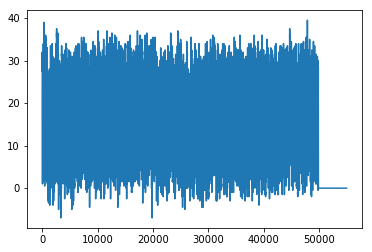

In [17]:
%matplotlib inline
plt.plot(c[0:5000*11,1])

In [1]:
cd ..

/home/nfcontrol/temp/rtcwleegfmri


In [3]:
ls

bin/                  LICENSE    requirements.txt  tests/
docs/                 Makefile   RTCWLEEGFMRI/     tmp/
guides_for_python.py  README.md  setup.py          Untitled.ipynb


In [2]:
cd RTCWLEEGFMRI/

/home/nfcontrol/temp/rtcwleegfmri/RTCWLEEGFMRI


In [5]:
ls

container_old.py  container.pyc  helpers.py   overview.py   ReceiveData.py
container.py      core.py        __init__.py  __pycache__/
